##Estimating Future Spend

In the previous notebook, we examined how customers in a non-subscription model disengage over time.  Without formal contracts in place between retailers and customers, we are left to estimate the probability a customer has dropped out of an on-going relationship based on their historical patterns of engagement relative to those of other customers. Understanding the probability a customer remains actively engaged is highly valuable in its own right.  But we can take it one step further and calculate how much revenue or profit we might derive from this predicted future engagement. 

To do this, we must build a model calculating the monetary value associated with future purchase events.  The purpose of this model is to derive such a model and combine it with lifetime probabilities to derive estimated Customer Lifetime Value.

###Step 1: Setup the Environment

As before, you need to attach this notebook to a cluster running the **Databricks ML runtime** version 6.5 or higher with the following libraries [installed](https://docs.databricks.com/libraries.html#workspace-libraries) and [attached](https://docs.databricks.com/libraries.html#install-a-library-on-a-cluster):</p>

* xlrd
* lifetimes==0.10.1
* nbconvert

In addition, you need to load the [Online Retail Data Set](http://archive.ics.uci.edu/ml/datasets/Online+Retail) available from the UCI Machine Learning Repository to the */FileStore/tables/online_retail/* folder in your environment, as described in the previous notebook. With prerequisites in place, we can access the dataset as follows:

In [0]:
import pandas as pd
import numpy as np

# identify name of xlsx file (which can change when uploaded)
xlsx_filename = dbutils.fs.ls('file:///dbfs/FileStore/tables/online_retail')[0][0]

# schema of the excel spreadsheet data range
orders_schema = {
  'InvoiceNo':np.str,
  'StockCode':np.str,
  'Description':np.str,
  'Quantity':np.int64,
  'InvoiceDate':np.datetime64,
  'UnitPrice':np.float64,
  'CustomerID':np.str,
  'Country':np.str  
  }

# read spreadsheet to pandas dataframe
# the xlrd library (loaded at the top of this notebook) is required for this step to work 
orders_pd = pd.read_excel(
  xlsx_filename, 
  sheet_name='Online Retail',
  header=0, # first row is header
  dtype=orders_schema
  )

In order to examine the monetary value associated with customer purchases, we need to calculate the amount of each sale in the online retail orders data set. This is done by simply multiplying Quantity by UnitPrice to create a new SalesAmount field:

In [0]:
# calculate sales amount as quantity * unit price
orders_pd['SalesAmount'] = orders_pd['Quantity'] * orders_pd['UnitPrice']

orders_pd.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08


Let's now make this data available to Spark for later use:

In [0]:
# convert pandas DF to Spark DF
orders = spark.createDataFrame(orders_pd)

# present Spark DF as queriable view
orders.createOrReplaceTempView('orders') 

###Step 2: Explore the Dataset

For an examination of the purchase frequency patterns in the dataset, we'll refer you to the Step 2 section of the prior notebook.  Here, we wish to examine patterns related to customer spend.  

To get started, let's take a look at the typical daily spend of a customer.  We will group this at a daily level because like with the customer lifetime calculations, we will consider multiple purchases on the same day to be part of the same purchase event:

In [0]:
%sql -- daily sales by customer

SELECT
  CustomerID,
  TO_DATE(InvoiceDate) as InvoiceDate,
  SUM(SalesAmount) as SalesAmount
FROM orders
GROUP BY CustomerID, TO_DATE(InvoiceDate)

CustomerID,InvoiceDate,SalesAmount
17975,2010-12-08,314.09999999999997
14413,2010-12-12,122.7
16955,2010-12-14,-25.0
13769,2010-12-14,-1.7
14560,2010-12-23,-9.95
17675,2011-01-05,969.3599999999999
12971,2011-01-06,185.10000000000002
17324,2011-01-12,575.18
13246,2011-01-17,347.03999999999996
16997,2011-01-18,390.0


The range of daily spend is quite wide with a few customers purchasing over £70,000 in a single day.  Without much knowledge of the underlying business, it's hard to say if this is level of spending is consistent with the expectations of the site or an outlier which should be removed.  

Notice too that there are quite a few negative values which are most likely associated with returns.  We'll discuss this more later in this notebook, but for now, we'll narrow the range of values we are examining to get a sense of the distribution of the bulk of the activity observed on the site:

In [0]:
%sql -- daily sales by customer (for daily sales between 0 and 2500£)

SELECT
  CustomerID,
  TO_DATE(InvoiceDate) as InvoiceDate,
  SUM(SalesAmount) as SalesAmount
FROM orders
GROUP BY CustomerID, TO_DATE(InvoiceDate)
HAVING SalesAmount BETWEEN 0 AND 2500

CustomerID,InvoiceDate,SalesAmount
13854,2011-01-24,304.09999999999997
16531,2011-01-25,146.1
13784,2011-02-01,155.51999999999998
15570,2011-02-10,61.3
16509,2011-02-16,363.7
17135,2011-02-23,284.97
15606,2011-02-24,305.7
17243,2011-02-27,373.6499999999999
14560,2011-03-01,34.75
17567,2011-03-03,535.38


The distribution of daily spend in this narrowed range is centered around 200 to 400 pound sterling with a long-tail towards higher ranges of spend. It's clear this is not a normal (gaussian) distribution.

This same distribution pattern is observed in the spending patterns of individual customers. Focusing on a few customers with a high number of purchases, you can see that spending patterns vary but this right-skewed pattern persists:

In [0]:
%sql -- top customers by frequency

SELECT
  CustomerID,
  COUNT(DISTINCT TO_DATE(InvoiceDate)) as Frequency
FROM orders
GROUP BY CustomerID
ORDER BY Frequency DESC
LIMIT 5

CustomerID,Frequency
null,277
14911,146
12748,115
17841,113
15311,91


In [0]:
%sql -- daily spend for three most frequent customers

SELECT
  CustomerID,
  TO_DATE(InvoiceDate) as InvoiceDate,
  SUM(SalesAmount) as SalesAmount
FROM orders
WHERE CustomerID IN (14911, 12748, 17841)
GROUP BY CustomerID, TO_DATE(InvoiceDate)
ORDER BY CustomerID

CustomerID,InvoiceDate,SalesAmount
12748,2011-10-09,224.52999999999992
12748,2011-07-29,161.67999999999998
12748,2011-11-02,263.53999999999996
12748,2010-12-10,1416.9800000000007
12748,2011-05-05,211.14999999999998
12748,2011-05-27,113.33000000000001
12748,2011-05-06,395.5999999999997
12748,2011-06-17,68.43999999999998
12748,2011-05-01,2.1
12748,2011-08-03,-11.299999999999999


There's a bit more we need to examine in this dataset but first we must calculate some per-customer metrics.

###Step 3: Calculate Customer Metrics

The dataset with which we are working contains raw transactional history.  As before, we need to calculate the per-customer metrics of frequency, age (T), and recency but we also need to calculate a monetary value metric:</p>

* **Frequency** - the number of dates on which a customer made a purchase subsequent to the date of the customer's first purchase.
* **Age (T)** - the number of time units, *e.g.* days, since the date of a customer's first purchase to the current date (or last date in the dataset).
* **Recency** - the age of the customer (as previously defined) at the time of their last purchase.
* **Monetary Value** - the average per transaction-date spend by a customer during repeat purchases.  (Margin and other monetary values may also be used if available.)

It's important to note that when calculating metrics such as customer age that we need to consider when our dataset terminates.  Calculating these metrics relative to today's date can lead to erroneous results.  Given this, we will identify the last date in the dataset and define that as *today's date* for all calculations.

To derive these metrics, we may make use of some built-in functionality in the [lifetimes](https://lifetimes.readthedocs.io/en/latest/lifetimes.html) library.  If you've reviewed the code in the prior notebook, you may recognize the method being called is identical to the one used before.  The only difference is that we are instructing the method to use our SalesAmount field as our measure of monetary value:

In [0]:
import lifetimes

# set the last transaction date as the end point for this historical dataset
current_date = orders_pd['InvoiceDate'].max()

# calculate the required customer metrics
metrics_pd = (
  lifetimes.utils.summary_data_from_transaction_data(
    orders_pd,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date, 
    freq='D',
    monetary_value_col='SalesAmount'  # use sales amount to determine monetary value
    )
  )

# display first few rows
metrics_pd.head(10)

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000
12352,6.0,260.0,296.0,208.151667
12353,0.0,0.0,204.0,0.000000
12354,0.0,0.0,232.0,0.000000
12355,0.0,0.0,214.0,0.000000


As before, let's examine how we might generate this same dataset using Spark so that when working with larger datasets, we can calculate these values in a parallelized manner.  Just like before, the logic in the next two cells demonstrates how we might do this using first a SQL statement and then the Programmatic SQL API.  We've worked to keep the code as consistent with the prior notebook whenever possible with the exception of the additional logic required for the monetary value logic:

In [0]:
# sql statement to derive summary customer stats
sql = '''
  SELECT
    a.customerid as CustomerID,
    CAST(COUNT(DISTINCT a.transaction_at) - 1 as float) as frequency,
    CAST(DATEDIFF(MAX(a.transaction_at), a.first_at) as float) as recency,
    CAST(DATEDIFF(a.current_dt, a.first_at) as float) as T,
    CASE                                              -- MONETARY VALUE CALCULATION
      WHEN COUNT(DISTINCT a.transaction_at)=1 THEN 0    -- 0 if only one order
      ELSE
        SUM(
          CASE WHEN a.first_at=a.transaction_at THEN 0  -- daily average of all but first order
          ELSE a.salesamount
          END
          ) / (COUNT(DISTINCT a.transaction_at)-1)
      END as monetary_value    
  FROM ( -- customer order history
    SELECT
      x.customerid,
      z.first_at,
      x.transaction_at,
      y.current_dt,
      x.salesamount                  
    FROM (                                            -- customer daily summary
      SELECT 
        customerid, 
        TO_DATE(invoicedate) as transaction_at, 
        SUM(SalesAmount) as salesamount               -- SALES AMOUNT ADDED
      FROM orders 
      GROUP BY customerid, TO_DATE(invoicedate)
      ) x
    CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_dt FROM orders) y                                -- current date (according to dataset)
    INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_at FROM orders GROUP BY customerid) z  -- first order per customer
      ON x.customerid=z.customerid
    WHERE x.customerid IS NOT NULL
    ) a
  GROUP BY a.customerid, a.current_dt, a.first_at
  ORDER BY CustomerID
  '''

# capture stats in dataframe 
metrics_sql = spark.sql(sql)

# display stats
display(metrics_sql)  

CustomerID,frequency,recency,T,monetary_value
12346,0.0,0.0,325.0,0.0
12347,6.0,365.0,367.0,599.7016666666667
12348,3.0,283.0,358.0,301.47999999999996
12349,0.0,0.0,18.0,0.0
12350,0.0,0.0,310.0,0.0
12352,6.0,260.0,296.0,208.15166666666664
12353,0.0,0.0,204.0,0.0
12354,0.0,0.0,232.0,0.0
12355,0.0,0.0,214.0,0.0
12356,2.0,303.0,325.0,269.905


In [0]:
# programmatic sql api calls to derive summary customer stats

from pyspark.sql.functions import to_date, datediff, max, min, countDistinct, count, sum, when
from pyspark.sql.types import *

# valid customer orders
x = (
    orders
      .where(orders.CustomerID.isNotNull())
      .withColumn('transaction_at', to_date(orders.InvoiceDate))
      .groupBy(orders.CustomerID, 'transaction_at')
      .agg(sum(orders.SalesAmount).alias('salesamount'))   # SALES AMOUNT
    )

# calculate last date in dataset
y = (
  orders
    .groupBy()
    .agg(max(to_date(orders.InvoiceDate)).alias('current_dt'))
  )

# calculate first transaction date by customer
z = (
  orders
    .groupBy(orders.CustomerID)
    .agg(min(to_date(orders.InvoiceDate)).alias('first_at'))
  )

# combine customer history with date info 
a = (x
    .crossJoin(y)
    .join(z, x.CustomerID==z.CustomerID, how='inner')
    .select(
      x.CustomerID.alias('customerid'), 
      z.first_at, 
      x.transaction_at,
      x.salesamount,               # SALES AMOUNT
      y.current_dt
      )
    )

# calculate relevant metrics by customer
metrics_api = (a
           .groupBy(a.customerid, a.current_dt, a.first_at)
           .agg(
             (countDistinct(a.transaction_at)-1).cast(FloatType()).alias('frequency'),
             datediff(max(a.transaction_at), a.first_at).cast(FloatType()).alias('recency'),
             datediff(a.current_dt, a.first_at).cast(FloatType()).alias('T'),
             when(countDistinct(a.transaction_at)==1,0)                           # MONETARY VALUE
               .otherwise(
                 sum(
                   when(a.first_at==a.transaction_at,0)
                     .otherwise(a.salesamount)
                   )/(countDistinct(a.transaction_at)-1)
                 ).alias('monetary_value')
               )
           .select('customerid','frequency','recency','T','monetary_value')
           .orderBy('customerid')
          )

display(metrics_api)

customerid,frequency,recency,T,monetary_value
12346,0.0,0.0,325.0,0.0
12347,6.0,365.0,367.0,599.7016666666667
12348,3.0,283.0,358.0,301.47999999999996
12349,0.0,0.0,18.0,0.0
12350,0.0,0.0,310.0,0.0
12352,6.0,260.0,296.0,208.15166666666664
12353,0.0,0.0,204.0,0.0
12354,0.0,0.0,232.0,0.0
12355,0.0,0.0,214.0,0.0
12356,2.0,303.0,325.0,269.905


And as before, we can use some summary stats to verify the datasets generated via SQL are identical to those generated by the lifetimes library:

In [0]:
# summary data from lifetimes
metrics_pd.describe()

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723010,225.304209,213.254316
std,6.674343,133.000474,118.384168,372.810217
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.955000
75%,4.000000,256.000000,331.000000,304.942500
max,145.000000,373.000000,373.000000,8866.081538


In [0]:
# summary data from SQL statement
metrics_sql.toPandas().describe()

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723007,225.304214,213.254316
std,6.674344,133.000473,118.384171,372.810217
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.955000
75%,4.000000,256.000000,331.000000,304.942500
max,145.000000,373.000000,373.000000,8866.081538


In [0]:
# summary data from pyspark.sql API
metrics_api.toPandas().describe()

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723007,225.304214,213.254316
std,6.674344,133.000473,118.384171,372.810217
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.955000
75%,4.000000,256.000000,331.000000,304.942500
max,145.000000,373.000000,373.000000,8866.081538


Expanding these calculations to derive values for calibration and holdout periods, the logic is as follows:

NOTE Again, we are using a widget to define the number of days in the holdout period.

In [0]:
# define a notebook parameter making holdout days configurable (90-days default)
dbutils.widgets.text('holdout days', '90')

In [0]:
from datetime import timedelta

# set the last transaction date as the end point for this historical dataset
current_date = orders_pd['InvoiceDate'].max()

# define end of calibration period
holdout_days = int(dbutils.widgets.get('holdout days'))
calibration_end_date = current_date - timedelta(days = holdout_days)

# calculate the required customer metrics
metrics_cal_pd = (
  lifetimes.utils.calibration_and_holdout_data(
    orders_pd,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D',
    monetary_value_col='SalesAmount'  # use sales amount to determine monetary value
    )
  )

# display first few rows
metrics_cal_pd.head(10)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,235.0,0.0000,0.0,0.000000,<90 * Days>
12347,4.0,238.0,277.0,519.7675,2.0,26.192069,<90 * Days>
12348,2.0,110.0,268.0,297.2200,1.0,103.333333,<90 * Days>
12350,0.0,0.0,220.0,0.0000,0.0,0.000000,<90 * Days>
12352,3.0,34.0,206.0,101.5600,3.0,20.090000,<90 * Days>
12353,0.0,0.0,114.0,0.0000,0.0,0.000000,<90 * Days>
12354,0.0,0.0,142.0,0.0000,0.0,0.000000,<90 * Days>
12355,0.0,0.0,124.0,0.0000,0.0,0.000000,<90 * Days>
12356,1.0,80.0,235.0,481.4600,1.0,29.175000,<90 * Days>


Implementing the required logic in SQL and using the Programmatic SQL API, we arrive at the following:

In [0]:
sql = '''
WITH CustomerHistory 
  AS (
    SELECT  -- nesting req'ed b/c can't SELECT DISTINCT on widget parameter
      m.*,
      getArgument('holdout days') as duration_holdout
    FROM (
      SELECT
        x.customerid,
        z.first_at,
        x.transaction_at,
        y.current_dt,
        x.salesamount
      FROM (                                            -- CUSTOMER DAILY SUMMARY
        SELECT 
          customerid, 
          TO_DATE(invoicedate) as transaction_at, 
          SUM(SalesAmount) as salesamount 
        FROM orders 
        GROUP BY customerid, TO_DATE(invoicedate)
        ) x
      CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_dt FROM orders) y                                -- current date (according to dataset)
      INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_at FROM orders GROUP BY customerid) z  -- first order per customer
        ON x.customerid=z.customerid
      WHERE x.customerid is not null
      ) m
  )
SELECT
    a.customerid as CustomerID,
    a.frequency as frequency_cal,
    a.recency as recency_cal,
    a.T as T_cal,
    COALESCE(a.monetary_value,0.0) as monetary_value_cal,
    COALESCE(b.frequency_holdout, 0.0) as frequency_holdout,
    COALESCE(b.monetary_value_holdout, 0.0) as monetary_value_holdout,
    a.duration_holdout
FROM ( -- CALIBRATION PERIOD CALCULATIONS
    SELECT
        p.customerid,
        CAST(p.duration_holdout as float) as duration_holdout,
        CAST(DATEDIFF(MAX(p.transaction_at), p.first_at) as float) as recency,
        CAST(COUNT(DISTINCT p.transaction_at) - 1 as float) as frequency,
        CAST(DATEDIFF(DATE_SUB(p.current_dt, p.duration_holdout), p.first_at) as float) as T,
        CASE                                              -- MONETARY VALUE CALCULATION
          WHEN COUNT(DISTINCT p.transaction_at)=1 THEN 0    -- 0 if only one order
          ELSE
            SUM(
              CASE WHEN p.first_at=p.transaction_at THEN 0  -- daily average of all but first order
              ELSE p.salesamount
              END
              ) / (COUNT(DISTINCT p.transaction_at)-1)
          END as monetary_value    
    FROM CustomerHistory p
    WHERE p.transaction_at < DATE_SUB(p.current_dt, p.duration_holdout)  -- LIMIT THIS QUERY TO DATA IN THE CALIBRATION PERIOD
    GROUP BY p.customerid, p.duration_holdout, p.current_dt, p.first_at
  ) a
LEFT OUTER JOIN ( -- HOLDOUT PERIOD CALCULATIONS
  SELECT
    p.customerid,
    CAST(COUNT(DISTINCT p.transaction_at) as float) as frequency_holdout,
    AVG(p.salesamount) as monetary_value_holdout      -- MONETARY VALUE CALCULATION
  FROM CustomerHistory p
  WHERE 
    p.transaction_at >= DATE_SUB(p.current_dt, p.duration_holdout) AND  -- LIMIT THIS QUERY TO DATA IN THE HOLDOUT PERIOD
    p.transaction_at <= p.current_dt
  GROUP BY p.customerid
  ) b
  ON a.customerid=b.customerid
ORDER BY CustomerID
'''

metrics_cal_sql = spark.sql(sql)
display(metrics_cal_sql)

CustomerID,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
12346,0.0,0.0,235.0,0.0,0.0,0.0,90.0
12347,4.0,238.0,277.0,519.7674999999999,2.0,759.57,90.0
12348,2.0,110.0,268.0,297.21999999999997,1.0,310.0,90.0
12350,0.0,0.0,220.0,0.0,0.0,0.0,90.0
12352,3.0,34.0,206.0,101.55999999999999,3.0,314.74333333333334,90.0
12353,0.0,0.0,114.0,0.0,0.0,0.0,90.0
12354,0.0,0.0,142.0,0.0,0.0,0.0,90.0
12355,0.0,0.0,124.0,0.0,0.0,0.0,90.0
12356,1.0,80.0,235.0,481.46,1.0,58.349999999999994,90.0
12358,0.0,0.0,60.0,0.0,1.0,683.2,90.0


In [0]:
from pyspark.sql.functions import avg, date_sub, coalesce, lit, expr

# valid customer orders
x = (
  orders
    .where(orders.CustomerID.isNotNull())
    .withColumn('transaction_at', to_date(orders.InvoiceDate))
    .groupBy(orders.CustomerID, 'transaction_at')
    .agg(sum(orders.SalesAmount).alias('salesamount'))
  )

# calculate last date in dataset
y = (
  orders
    .groupBy()
    .agg(max(to_date(orders.InvoiceDate)).alias('current_dt'))
  )

# calculate first transaction date by customer
z = (
  orders
    .groupBy(orders.CustomerID)
    .agg(min(to_date(orders.InvoiceDate)).alias('first_at'))
  )

# combine customer history with date info (CUSTOMER HISTORY)
p = (x
    .crossJoin(y)
    .join(z, x.CustomerID==z.CustomerID, how='inner')
    .withColumn('duration_holdout', lit(int(dbutils.widgets.get('holdout days'))))
    .select(
      x.CustomerID.alias('customerid'),
      z.first_at, 
      x.transaction_at, 
      y.current_dt, 
      x.salesamount,
      'duration_holdout'
      )
     .distinct()
    )

# calculate relevant metrics by customer
# note: date_sub requires a single integer value unless employed within an expr() call
a = (p
       .where(p.transaction_at < expr('date_sub(current_dt, duration_holdout)')) 
       .groupBy(p.customerid, p.current_dt, p.duration_holdout, p.first_at)
       .agg(
         (countDistinct(p.transaction_at)-1).cast(FloatType()).alias('frequency_cal'),
         datediff( max(p.transaction_at), p.first_at).cast(FloatType()).alias('recency_cal'),
         datediff( expr('date_sub(current_dt, duration_holdout)'), p.first_at).cast(FloatType()).alias('T_cal'),
         when(countDistinct(p.transaction_at)==1,0)
           .otherwise(
             sum(
               when(p.first_at==p.transaction_at,0)
                 .otherwise(p.salesamount)
               )/(countDistinct(p.transaction_at)-1)
             ).alias('monetary_value_cal')
       )
    )

b = (p
      .where((p.transaction_at >= expr('date_sub(current_dt, duration_holdout)')) & (p.transaction_at <= p.current_dt) )
      .groupBy(p.customerid)
      .agg(
        countDistinct(p.transaction_at).cast(FloatType()).alias('frequency_holdout'),
        avg(p.salesamount).alias('monetary_value_holdout')
        )
   )

metrics_cal_api = (
                 a
                 .join(b, a.customerid==b.customerid, how='left')
                 .select(
                   a.customerid.alias('CustomerID'),
                   a.frequency_cal,
                   a.recency_cal,
                   a.T_cal,
                   a.monetary_value_cal,
                   coalesce(b.frequency_holdout, lit(0.0)).alias('frequency_holdout'),
                   coalesce(b.monetary_value_holdout, lit(0.0)).alias('monetary_value_holdout'),
                   a.duration_holdout
                   )
                 .orderBy('CustomerID')
              )

display(metrics_cal_api)

CustomerID,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
12346,0.0,0.0,235.0,0.0,0.0,0.0,90
12347,4.0,238.0,277.0,519.7674999999999,2.0,759.57,90
12348,2.0,110.0,268.0,297.21999999999997,1.0,310.0,90
12350,0.0,0.0,220.0,0.0,0.0,0.0,90
12352,3.0,34.0,206.0,101.55999999999999,3.0,314.74333333333334,90
12353,0.0,0.0,114.0,0.0,0.0,0.0,90
12354,0.0,0.0,142.0,0.0,0.0,0.0,90
12355,0.0,0.0,124.0,0.0,0.0,0.0,90
12356,1.0,80.0,235.0,481.46,1.0,58.349999999999994,90
12358,0.0,0.0,60.0,0.0,1.0,683.2,90


And now we compare the results:

In [0]:
# summary data from lifetimes
metrics_cal_pd.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000
mean,2.677608,90.587046,185.041618,190.242725,1.502345,17.999563
std,5.222838,96.077761,80.771943,362.064653,2.495318,77.381388
min,0.000000,0.000000,1.000000,-1462.500000,0.000000,-114.000000
25%,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000
50%,1.000000,59.500000,197.000000,111.000000,1.000000,6.286336
75%,3.000000,175.000000,268.000000,276.768000,2.000000,19.131176
max,93.000000,282.000000,283.000000,7860.345833,52.000000,2685.000000


In [0]:
# summary data from SQL statement
metrics_cal_sql.toPandas().describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587044,185.041611,190.242725,1.502345,236.965305,90.0
std,5.222837,96.077766,80.771942,362.064653,2.495318,472.652180,0.0
min,0.000000,0.000000,1.000000,-1462.500000,0.000000,-468.320000,90.0
25%,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,111.000000,1.000000,126.677500,90.0
75%,3.000000,175.000000,268.000000,276.768000,2.000000,324.202500,90.0
max,93.000000,282.000000,283.000000,7860.345833,52.000000,12420.655000,90.0


In [0]:
# summary data from pyspark.sql API
metrics_cal_api.toPandas().describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587044,185.041611,190.242725,1.502345,236.965305,90.0
std,5.222837,96.077766,80.771942,362.064653,2.495318,472.652180,0.0
min,0.000000,0.000000,1.000000,-1462.500000,0.000000,-468.320000,90.0
25%,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,111.000000,1.000000,126.677500,90.0
75%,3.000000,175.000000,268.000000,276.768000,2.000000,324.202500,90.0
max,93.000000,282.000000,283.000000,7860.345833,52.000000,12420.655000,90.0


Carefully examine the monetary holdout value calculated with the lifetimes library.  You should notice the values produced are significantly lower than those arrived at by the Spark code.  This is because the lifetimes library is averaging the individual line items on a given transaction date instead of averaging the transaction date total.  A change request has been submitted with the caretakers of the lifetimes library, but we believe the average of transaction date totals is the correct value and will use that for the remainder of this notebook.

If you'd like to examine how values identical to those currently produced by the lifetimes library can be created using Spark, we've recreated the lifetimes logic using SQL here and provided a summary comparison in the two cells that follow:

In [0]:
sql = '''
WITH CustomerHistory 
  AS (
    SELECT  -- nesting req'ed b/c can't SELECT DISTINCT on widget parameter
      m.*,
      getArgument('holdout days') as duration_holdout
    FROM (
      SELECT
        x.customerid,
        z.first_at,
        x.transaction_at,
        y.current_dt,
        x.salesamount
      FROM (                                            -- CUSTOMER DAILY SUMMARY
        SELECT 
          customerid, 
          TO_DATE(invoicedate) as transaction_at, 
          SUM(SalesAmount) as salesamount 
        FROM orders 
        GROUP BY customerid, TO_DATE(invoicedate)
        ) x
      CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_dt FROM orders) y                                -- current date (according to dataset)
      INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_at FROM orders GROUP BY customerid) z  -- first order per customer
        ON x.customerid=z.customerid
      WHERE x.customerid is not null
      ) m
  )
SELECT
    a.customerid as CustomerID,
    a.frequency as frequency_cal,
    a.recency as recency_cal,
    a.T as T_cal,
    COALESCE(a.monetary_value,0.0) as monetary_value_cal,
    COALESCE(b.frequency_holdout, 0.0) as frequency_holdout,
    COALESCE(b.monetary_value_holdout, 0.0) as monetary_value_holdout,
    a.duration_holdout
FROM ( -- CALIBRATION PERIOD CALCULATIONS
    SELECT
        p.customerid,
        CAST(p.duration_holdout as float) as duration_holdout,
        CAST(DATEDIFF(MAX(p.transaction_at), p.first_at) as float) as recency,
        CAST(COUNT(DISTINCT p.transaction_at) - 1 as float) as frequency,
        CAST(DATEDIFF(DATE_SUB(p.current_dt, p.duration_holdout), p.first_at) as float) as T,
        CASE                                              -- MONETARY VALUE CALCULATION
          WHEN COUNT(DISTINCT p.transaction_at)=1 THEN 0    -- 0 if only one order
          ELSE
            SUM(
              CASE WHEN p.first_at=p.transaction_at THEN 0  -- daily average of all but first order
              ELSE p.salesamount
              END
              ) / (COUNT(DISTINCT p.transaction_at)-1)
          END as monetary_value    
    FROM CustomerHistory p
    WHERE p.transaction_at < DATE_SUB(p.current_dt, p.duration_holdout)  -- LIMIT THIS QUERY TO DATA IN THE CALIBRATION PERIOD
    GROUP BY p.customerid, p.duration_holdout, p.current_dt, p.first_at
  ) a
LEFT OUTER JOIN ( -- HOLDOUT PERIOD CALCULATIONS
  SELECT
    p.customerid,
    CAST(COUNT(DISTINCT TO_DATE(p.invoicedate)) as float) as frequency_holdout,
    AVG(p.salesamount) as monetary_value_holdout      -- MONETARY VALUE CALCULATION
  FROM orders p
  CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_dt FROM orders) q                                -- current date (according to dataset)
  INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_at FROM orders GROUP BY customerid) r  -- first order per customer
    ON p.customerid=r.customerid
  WHERE 
    p.customerid is not null AND
    TO_DATE(p.invoicedate) >= DATE_SUB(q.current_dt, getArgument('holdout days')) AND  -- LIMIT THIS QUERY TO DATA IN THE HOLDOUT PERIOD
    TO_DATE(p.invoicedate) <= q.current_dt
  GROUP BY p.customerid
  ) b
  ON a.customerid=b.customerid
ORDER BY CustomerID
'''

metrics_cal_sql_alt = spark.sql(sql)
display(metrics_cal_sql_alt)

CustomerID,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
12346,0.0,0.0,235.0,0.0,0.0,0.0,90.0
12347,4.0,238.0,277.0,519.7674999999999,2.0,26.192068965517244,90.0
12348,2.0,110.0,268.0,297.21999999999997,1.0,103.33333333333333,90.0
12350,0.0,0.0,220.0,0.0,0.0,0.0,90.0
12352,3.0,34.0,206.0,101.55999999999999,3.0,20.09,90.0
12353,0.0,0.0,114.0,0.0,0.0,0.0,90.0
12354,0.0,0.0,142.0,0.0,0.0,0.0,90.0
12355,0.0,0.0,124.0,0.0,0.0,0.0,90.0
12356,1.0,80.0,235.0,481.46,1.0,29.174999999999997,90.0
12358,0.0,0.0,60.0,0.0,1.0,97.60000000000001,90.0


In [0]:
# summary data from lifetimes
metrics_cal_pd.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000
mean,2.677608,90.587046,185.041618,190.242725,1.502345,17.999563
std,5.222838,96.077761,80.771943,362.064653,2.495318,77.381388
min,0.000000,0.000000,1.000000,-1462.500000,0.000000,-114.000000
25%,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000
50%,1.000000,59.500000,197.000000,111.000000,1.000000,6.286336
75%,3.000000,175.000000,268.000000,276.768000,2.000000,19.131176
max,93.000000,282.000000,283.000000,7860.345833,52.000000,2685.000000


In [0]:
# summary data from alternative sql statement recreating
# monetary_value_holdout as currently implemented in lifetimes
metrics_cal_sql_alt.toPandas().describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587044,185.041611,190.242725,1.502345,17.999563,90.0
std,5.222837,96.077766,80.771942,362.064653,2.495318,77.381388,0.0
min,0.000000,0.000000,1.000000,-1462.500000,0.000000,-114.000000,90.0
25%,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,111.000000,1.000000,6.286336,90.0
75%,3.000000,175.000000,268.000000,276.768000,2.000000,19.131176,90.0
max,93.000000,282.000000,283.000000,7860.345833,52.000000,2685.000000,90.0


Moving forward, we now need to limit our analysis to those customers with repeat purchases, just as we did in the prior notebook:

In [0]:
# remove customers with no repeats (complete dataset)
filtered = metrics_api.where(metrics_api.frequency > 0)

# remove customers with no repeats in calibration period
filtered_cal = metrics_cal_api.where(metrics_cal_api.frequency_cal > 0)

Finally, we need to consider what to do about the negative daily totals found in our dataset.  Without any contextual information about the retailer from which this dataset is derived, we might assume these negative values represent returns.  Ideally, we'd match returns to their original purchases and adjust the monetary values for the original transaction date.  That said, we do not have the information required to consistently do this and so we will simply include the negative return values in our daily transaction totals. Where this causes a daily total to be £0 or lower, we will simply exclude that value from our analysis.  Outside of a demonstration setting, this would typically be inappropriate:

In [0]:
# exclude dates with negative totals (see note above) 
filtered = filtered.where(filtered.monetary_value > 0)
filtered_cal = filtered_cal.where(filtered_cal.monetary_value_cal > 0)

###Step 4: Verifying Frequency & Monetary Value Independence

Before proceeding with our modeling, the gamma-gamma model (named for the two gamma distributions described earlier) that we will employ assumes that the frequency of a customer's purchases does not affect the monetary value of those purchases.  It's important that we test this and we can do so with the calculation of a simple Pearson's coefficient against our frequency and monetary value metrics.  We'll do this for the entire dataset, ignoring the calibration and holdout subsets, for this one analysis:

In [0]:
filtered.corr('frequency', 'monetary_value')

Out[62]: 0.17498384279151702

While not perfectly independent, the correlation between these two values is pretty low so that we should be able to proceed with model training.

###Step 5: Train the Spend Model

With our metrics in place, we can now train a model to estimate the monetary value to be derived from a future transactional event. The model we will use is referred to as the [Gamma-Gamma model](http://www.brucehardie.com/notes/025/gamma_gamma.pdf) in that it fits the gamma-distribution of an individual customer's spend against a gamma-distributed parameter that's derived from the customer population's spending distribution. The math is complex but the implementation is pretty straightforward using the lifetimes library.

That said, we must first determine the best value for the L2-regularization parameter used by the model.  For this, we will return to [hyperopt](http://hyperopt.github.io/hyperopt/), leveraging near identical patterns explored in the previous notebook:

In [0]:
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval

from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

# define search space
search_space = hp.uniform('l2', 0.0, 1.0)

# evaluation function
def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

# define function for model training and evaluation
def evaluate_model(param):
  
  # accesss replicated input_pd dataframe
  data = inputs.value
  
  # retrieve incoming parameters
  l2_reg = param
  
  # instantiate and configure the model
  model = GammaGammaFitter(penalizer_coef=l2_reg)
  
  # fit the model
  model.fit(data['frequency_cal'], data['monetary_value_cal'])
  
  # evaluate the model
  monetary_actual = data['monetary_value_holdout']
  monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
  mse = score_model(monetary_actual, monetary_predicted, 'mse')
  
  # return score and status
  return {'loss': mse, 'status': STATUS_OK}

In [0]:
# configure hyperopt settings to distribute to all executors on workers
spark_trials = SparkTrials(parallelism=2)

# select optimization algorithm
algo = tpe.suggest

# replicate input_pd dataframe to workers in Spark cluster
input_pd = filtered_cal.where(filtered_cal.monetary_value_cal > 0).toPandas()
inputs = sc.broadcast(input_pd)

# perform hyperparameter tuning (logging iterations to mlflow)
argmin = fmin(
  fn=evaluate_model,
  space=search_space,
  algo=algo,
  max_evals=100,
  trials=spark_trials
  )

# release the broadcast dataset
inputs.unpersist()

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks; Task 0 is the first trial attempt, and subsequent Tasks are retries. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/100 [00:00<?, ?trial/s, best loss=?] 1%| | 1/100 [00:05<08:30, 5.15s/trial, best loss: 1488996.2173364349] 2%|▏ | 2/100 [00:07<06:52, 4.21s/trial, best loss: 1488996.2173364349] 3%|▎ | 3/100 [00:10<06:13, 3.85s/trial, best loss: 1488996.2173364349] 4%|▍ | 4/100 [00:11<04:47, 2.99s/trial, best loss: 1488996.2173364349] 5%|▌ | 5/100 [00:15<05:13, 3.30s/trial, best loss: 1488996.2173364349] 6%|▌ | 6/100 [00:16<04:05, 2.61s/trial, best loss: 1488996.2173364349] 7%|▋ | 7/100 [00:20<04:41, 3.03s/trial, best loss: 1488996.2173364349] 8%|▊ | 8/100 [00:22<04:10, 2.72s/trial, best loss: 1488996.2173364349] 9%|▉ | 9/100 [00:25<04:15, 2.81s/trial, best loss: 1488996.2173364349] 10%|█ | 10/100 [00:27<03:50, 2.57s/trial, best loss: 1488996.2173364349] 11%|█ | 11/100 [00:30<04:00, 2.70s/trial, best loss: 1488996.2173364349] 12%|█▏ | 12/100 [00:32<03:39, 2.49s/trial, best loss: 1488996.2173364349] 13%|█▎ | 13/100 [00:35<03:50, 2.64s/trial, best loss: 1488996.2173364349] 14%|█▍ | 14/100 [00:36<03:09, 2.20s/trial, best loss: 278141.99103157496] 15%|█▌ | 15/100 [00:40<03:52, 2.74s/trial, best loss: 278141.99103157496] 16%|█▌ | 16/100 [00:41<03:06, 2.22s/trial, best loss: 278141.99103157496] 17%|█▋ | 17/100 [00:46<04:17, 3.10s/trial, best loss: 266973.4166281256]  18%|█▊ | 18/100 [00:47<03:22, 2.47s/trial, best loss: 266973.4166281256] 19%|█▉ | 19/100 [00:51<03:57, 2.93s/trial, best loss: 266973.4166281256] 20%|██ | 20/100 [00:52<03:08, 2.35s/trial, best loss: 266973.4166281256] 21%|██ | 21/100 [00:55<03:25, 2.60s/trial, best loss: 131765.26666198447] 22%|██▏ | 22/100 [00:57<03:12, 2.47s/trial, best loss: 18366.68345086413]  23%|██▎ | 23/100 [01:01<03:45, 2.93s/trial, best loss: 18366.68345086413] 24%|██▍ | 24/100 [01:04<03:24, 2.69s/trial, best loss: 2843.3731504744383] 25%|██▌ | 25/100 [01:06<03:06, 2.49s/trial, best loss: 2843.3731504744383] 26%|██▌ | 26/100 [01:09<03:15, 2.64s/trial, best loss: 2843.3731504744383] 27%|██▋ | 27/100 [01:11<02:58, 2.45s/trial, best loss: 2843.3731504744383] 28%|██▊ | 28/100 [01:15<03:30, 2.92s/trial, best loss: 2843.3731504744383] 29%|██▉ | 29/100 [01:17<03:07, 2.65s/trial, best loss: 2843.3731504744383] 30%|███ | 30/100 [01:20<03:12, 2.75s/trial, best loss: 2843.3731504744383] 31%|███ | 31/100 [01:22<02:54, 2.53s/trial, best loss: 2843.3731504744383] 32%|███▏ | 32/100 [01:24<02:41, 2.37s/trial, best loss: 2843.3731504744383] 33%|███▎ | 33/100 [01:27<02:51, 2.56s/trial, best loss: 2843.3731504744383] 34%|███▍ | 34/100 [01:29<02:38, 2.40s/trial, best loss: 2843.3731504744383] 35%|███▌ | 35/100 [01:32<02:47, 2.58s/trial, best loss: 2843.3731504744383] 36%|███▌ | 36/100 [01:34<02:34, 2.41s/trial, best loss: 2843.3731504744383] 37%|███▋ | 37/100 [01:36<02:24, 2.29s/trial, best loss: 2843.3731504744383] 38%|███▊ | 38/100 [01:39<02:35, 2.50s/trial, best loss: 2843.3731504744383] 39%|███▉ | 39/100 [01:41<02:23, 2.35s/trial, best loss: 2843.3731504744383] 40%|████ | 40/100 [01:44<02:32, 2.55s/trial, best loss: 2843.3731504744383] 41%|████ | 41/100 [01:46<02:20, 2.39s/trial, best loss: 2843.3731504744383] 42%|████▏ | 42/100 [01:48<02:11, 2.27s/trial, best loss: 2843.3731504744383] 43%|████▎ | 43/100 [01:51<02:22, 2.49s/trial, best loss: 2843.3731504744383] 44%|████▍ | 44/100 [01:53<02:11, 2.35s/trial, best loss: 2843.3731504744383] 45%|████▌ | 45/100 [01:56<02:19, 2.54s/trial, best loss: 2843.3731504744383] 4

In [0]:
# print optimum hyperparameter settings
print(space_eval(search_space, argmin))

0.002987796591588307

With our optimal L2 value identified, let's train the final spend model:

In [0]:
# get hyperparameter setting
l2_reg = space_eval(search_space, argmin)

# instantiate and configure model
spend_model = GammaGammaFitter(penalizer_coef=l2_reg)

# fit the model
spend_model.fit(input_pd['frequency_cal'], input_pd['monetary_value_cal'])

Out[66]: <lifetimes.GammaGammaFitter: fitted with 1965 subjects, p: 4.90, q: 0.50, v: 6.95>

###Step 6: Evaluate the Spend Model

The evaluation of the spend model is fairly straightforward.  We might examine how well predicted values align with actuals in the holdout period and derive an MSE from it:

In [0]:
# evaluate the model
monetary_actual = input_pd['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(input_pd['frequency_holdout'], input_pd['monetary_value_holdout'])
mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 2841.6187136702465

We might also visually inspect how are predicted spend values align with actuals, a technique employed in the [original paper](http://www.brucehardie.com/notes/025/gamma_gamma.pdf) that described the Gamma-Gamma model:

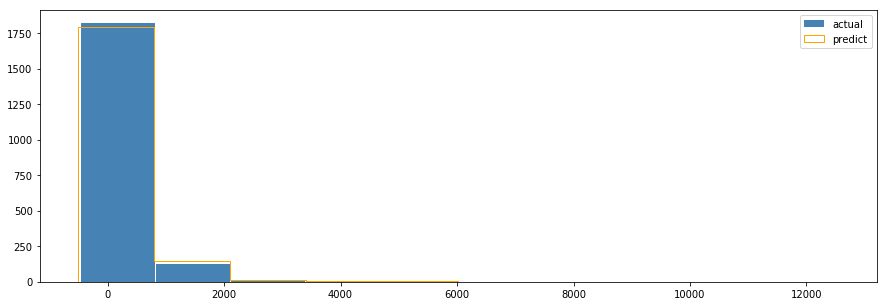

In [0]:
import matplotlib.pyplot as plt

# define histogram bin count
bins = 10

# plot size
plt.figure(figsize=(15, 5))

# histogram plot values and presentation
plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)

# place legend on chart
plt.legend(loc='upper right')

With only 10 bins, our model looks like it lines up with our actuals data pretty nicely.  If we expand the bin count, we see that the model underpredicts the occurrence of the lowest valued spend while following the remaining structure of the data.  Interestingly, a similar pattern was observed in the original paper cited earlier:

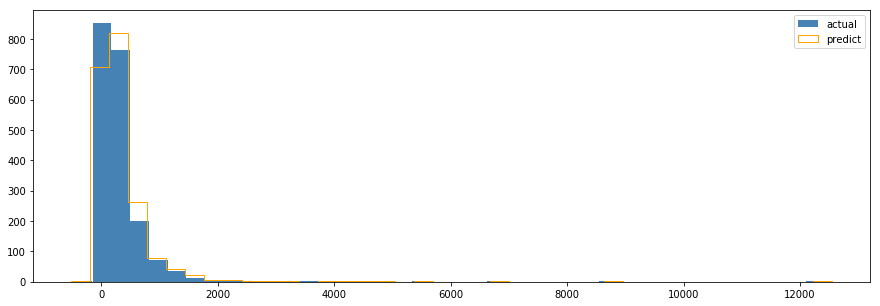

In [0]:
# define histogram bin count
bins = 40

# plot size
plt.figure(figsize=(15, 5))

# histogram plot values and presentation
plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)

# place legend on chart
plt.legend(loc='upper right')

###Step 7: Calculate Customer Lifetime Value

The spend model allows us to calculate the monetary value we may obtain from future purchase events.  When used in combination with the lifetime model which calculates the probable count of future spending events, we can derive a Customer Lifetime Value for a future period of time.

To demonstrate this, we must first train a lifetime model.  We'll use a BG/NBD model with an L2 parameter setting derived in an earlier execution of the prior notebook for this:

In [0]:
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter

lifetime_input_pd = filtered_cal.toPandas() # pull data into pandas from Spark dataframe

# instantiate & configure the model (provided settings from previous hyperparam tuning exercise)
lifetimes_model = BetaGeoFitter(penalizer_coef=0.9995179967263891)

# train the model
lifetimes_model.fit(lifetime_input_pd['frequency_cal'], lifetime_input_pd['recency_cal'], lifetime_input_pd['T_cal'])

# score the model
frequency_holdout_actual = lifetime_input_pd['frequency_holdout']
frequency_holdout_predicted = lifetimes_model.predict(lifetime_input_pd['duration_holdout'], lifetime_input_pd['frequency_cal'], lifetime_input_pd['recency_cal'], lifetime_input_pd['T_cal'])
mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 3.7153577743289667

Now we can use these together to calculate CLV. Here, we will calculate CLV over a 12-month period using a monthly discount rate of 1%:

NOTE The CFO typically defines a discount rate which should be used for these types of calculations.  Be sure the discount rate is expressed as a monthly discount rate.  If provided an annual discount rate, be sure to convert it to monthly using [this formula](https://www.experiglot.com/2006/06/07/how-to-convert-from-an-annual-rate-to-an-effective-periodic-rate-javascript-calculator/).

In [0]:
clv_input_pd = filtered.toPandas()

# calculate the 1-year CLV for each customer
clv_input_pd['clv'] = (
  spend_model.customer_lifetime_value(
    lifetimes_model, #the model to use to predict the number of future transactions
    clv_input_pd['frequency'],
    clv_input_pd['recency'],
    clv_input_pd['T'],
    clv_input_pd['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
  )
)

clv_input_pd.head(10)

,customerid,frequency,recency,T,monetary_value,clv
0,12347,6.0,365.0,367.0,599.701667,3431.803223
1,12348,3.0,283.0,358.0,301.480000,967.623817
2,12352,6.0,260.0,296.0,208.151667,1463.004047
3,12356,2.0,303.0,325.0,269.905000,689.918451
4,12358,1.0,149.0,150.0,683.200000,2204.576172
5,12359,5.0,324.0,331.0,1139.606000,6091.267446
6,12360,2.0,148.0,200.0,789.240000,3130.732492
7,12362,12.0,292.0,295.0,389.623333,5233.518458
8,12363,1.0,133.0,242.0,252.900000,539.449780
9,12364,3.0,105.0,112.0,229.726667,2103.405242


CLV is a powerful metric used by organizations to plan targeted promotional activities and assess customer equity. As such, it would be very helpful if we could convert our models into an easy to use function which we could employ in batch, streaming and interactive scenarios.

If you reviewed the prior notebook, you know where we are headed.  The one wrinkle we need to address here is that the CLV calculation depends on two models, not one.  Not a problem.  What we'll do is simply save the lifetime model as a pickled artifact associated with our spend model and in the custom wrapper we'll develop for our spend model, we'll re-instantiate the lifetime model so that it is available for predictions.

To get started, let's save our lifetime model to a temporary location:

In [0]:
# location to save temp copy of lifetimes model
lifetimes_model_path = '/dbfs/tmp/lifetimes_model.pkl'

# delete any prior copies that may exist
try:
  dbutils.fs.rm(lifetimes_model_path)
except:
  pass

# save the model to the temp location
lifetimes_model.save_model(lifetimes_model_path)

Now, let's define the custom wrapper for our spend model.  Notice that the *predict()* method is fairly simple and returns just a CLV value.  Notice too that it assumes a consistent value for month and discount rate is provided in the incoming data.

Besides modification to the *predict()* method logic, a new definition for *load_context()* is provided.  This method is called when an [mlflow](https://mlflow.org/) model is instantiated.  In it, we will load our lifetimes model artifact:

In [0]:
import mlflow 
import mlflow.pyfunc

# create wrapper for lifetimes model
class _clvModelWrapper(mlflow.pyfunc.PythonModel):
  
    def __init__(self, spend_model):
      self.spend_model = spend_model
        
    def load_context(self, context):
      # load base model fitter from lifetimes library
      from lifetimes.fitters.base_fitter import BaseFitter
      
      # instantiate lifetimes_model
      self.lifetimes_model = BaseFitter()
      
      # load lifetimes_model from mlflow
      self.lifetimes_model.load_model(context.artifacts['lifetimes_model'])
      
    def predict(self, context, dataframe):
      
      # access input series
      frequency = dataframe.iloc[:,0]
      recency = dataframe.iloc[:,1]
      T = dataframe.iloc[:,2]
      monetary_value = dataframe.iloc[:,3]
      months = int(dataframe.iloc[0,4])
      discount_rate = float(dataframe.iloc[0,5])
      
      # make CLV prediction
      results = pd.DataFrame(
          self.spend_model.customer_lifetime_value(
            self.lifetimes_model, #the model to use to predict the number of future transactions
            frequency,
            recency,
            T,
            monetary_value,
            time=months,
            discount_rate=discount_rate
            ),
          columns=['clv']
          )
      
      return results[['clv']]

Now we save our spend model to mlflow:

In [0]:
# add lifetimes to conda environment info
conda_env = mlflow.pyfunc.get_default_conda_env()
conda_env['dependencies'][1]['pip'] += ['lifetimes==0.10.1'] # version should match version installed at top of this notebook

# save model run to mlflow
with mlflow.start_run(run_name='deployment run') as run:
  
  # identify lifetime model as an artifact associated with the spend model
  artifacts = {'lifetimes_model': lifetimes_model_path}
  
  # log our spend model to mlflow
  mlflow.pyfunc.log_model(
    'model', 
    python_model=_clvModelWrapper(spend_model), 
    conda_env=conda_env,
    artifacts=artifacts
    )

And as before, we create a function from this model:

In [0]:
# define the schema of the values returned by the function
result_schema = DoubleType()

# define function based on mlflow recorded model
clv_udf = mlflow.pyfunc.spark_udf(
  spark, 
  'runs:/{0}/model'.format(run.info.run_id), 
  result_type=result_schema
  )

# register the function for use in SQL
_ = spark.udf.register('clv', clv_udf)

Our model is now available for use with the Programmatic SQL API:

In [0]:
# create a temp view for SQL demonstration (next cell)
filtered.createOrReplaceTempView('customer_metrics')

# demonstrate function call on Spark DataFrame
display(
  filtered
    .withColumn(
      'clv', 
      clv_udf(filtered.frequency, filtered.recency, filtered.T, filtered.monetary_value, lit(12), lit(0.01))
      )
    .selectExpr(
      'customerid', 
      'clv'
      )
  )

customerid,clv
12347,3431.80322265353
12348,967.6238167649877
12352,1463.0040470878348
12356,689.9184510794297
12358,2204.5761716808365
12359,6091.267446197621
12360,3130.732491548178
12362,5233.518458445535
12363,539.4497796187134
12364,2103.405242132716


It can also be used with SQL:

In [0]:
%sql -- retreive customer clv

SELECT
  customerid,
  clv(
    frequency,
    recency,
    T,
    monetary_value,
    12,
    0.01
    ) as clv
FROM customer_metrics;

customerid,clv
12347,3431.80322265353
12348,967.6238167649877
12352,1463.0040470878348
12356,689.9184510794297
12358,2204.5761716808365
12359,6091.267446197622
12360,3130.732491548178
12362,5233.518458445535
12363,539.4497796187134
12364,2103.405242132716
